In [ ]:
import os
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import scipy.io as sio
from scipy import fftpack
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, medfilt

from tensorflow.keras import layers, models, optimizers, callbacks

%matplotlib inline

### Downloading Dataset and extracting contents

---

In [ ]:
!wget -P ./ "https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz" -O "wisdm.tar.gz"

--2024-04-09 03:04:01--  https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
Resolving www.cis.fordham.edu (www.cis.fordham.edu)... 150.108.68.29
Connecting to www.cis.fordham.edu (www.cis.fordham.edu)|150.108.68.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11404612 (11M) [application/x-gzip]
Saving to: ‘wisdm.tar.gz’

sdm.tar.gz          100%[===================>]  10.88M  3.36MB/s    in 3.2s    

2024-04-09 03:04:05 (3.36 MB/s) - ‘wisdm.tar.gz’ saved [11404612/11404612]



In [ ]:
filename = './wisdm.tar.gz'
with tarfile.open(filename, 'r:gz') as tar:
  tar.extractall('./')

### Organizing data format,structure, and balancing dataset

---



In [ ]:
dataset_dir = './WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

In [ ]:
with open(dataset_dir, 'r') as f:
  lines = f.readlines()

a = []
for row in lines:
  a.append(row.split(';')[:-1])

b = []
for row in a:
  if len(row) == 1:
    temp = row[0].split(',')
    b.append([temp[0], temp[1], temp[2], temp[3], temp[4], temp[5]])
  else:
    for x in row:
      b.append(x.split(','))

b = np.array(b)

In [ ]:
cols_label = ['user', 'activity', 'timestamp', 'acc_x', 'acc_y', 'acc_z']
df = pd.DataFrame(data=b, columns=cols_label)

In [ ]:
df.head()

,user,activity,timestamp,acc_x,acc_y,acc_z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098208 entries, 0 to 1098207
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user       1098208 non-null  object
 1   activity   1098208 non-null  object
 2   timestamp  1098208 non-null  object
 3   acc_x      1098208 non-null  object
 4   acc_y      1098208 non-null  object
 5   acc_z      1098208 non-null  object
dtypes: object(6)
memory usage: 50.3+ MB


In [ ]:
df['user'] = df['user'].astype('string')
df['activity'] = df['activity'].astype('string')
df['timestamp'] = df['timestamp'].astype('int')
df['acc_x'] = df['acc_x'].astype('float')
df['acc_y'] = df['acc_y'].astype('float')
df['acc_z'] = df['acc_z'].astype('float')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098208 entries, 0 to 1098207
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098208 non-null  string 
 1   activity   1098208 non-null  string 
 2   timestamp  1098208 non-null  int64  
 3   acc_x      1098208 non-null  float64
 4   acc_y      1098208 non-null  float64
 5   acc_z      1098208 non-null  float64
dtypes: float64(3), int64(1), string(2)
memory usage: 50.3 MB


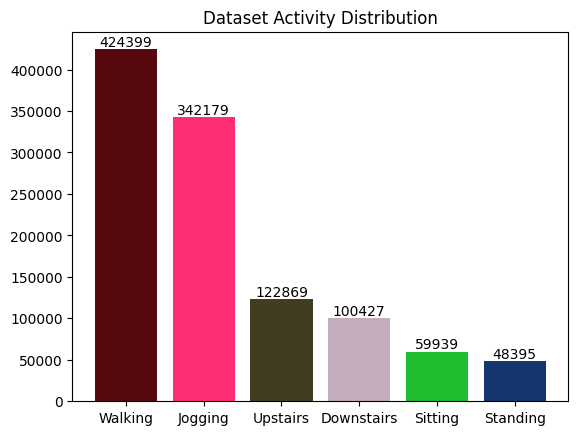

In [ ]:
activity_dist = df['activity'].value_counts()
plt.bar(x=activity_dist.keys(), height=activity_dist.values, color=np.random.rand(6, 3))
plt.title('Dataset Activity Distribution')
for i in range(len(activity_dist.keys())):
  plt.text(i, activity_dist.values[i], str(activity_dist.values[i]), ha='center', va='bottom')
plt.show()

In [ ]:
df['user'].unique()

<StringArray>
['33', '17', '20', '29', '13', '15',  '6', '27', '36', '18', '32', '35', '11',
 '16',  '5', '10', '28', '26', '14', '24', '12', '23',  '4', '30', '34',  '8',
 '31', '21',  '3', '22',  '1',  '9', '25',  '2',  '7', '19']
Length: 36, dtype: string

In [ ]:
# Check for missing values
missing_values = df.isnull()
if missing_values.any().any():
    print("There are missing values in the DataFrame.")

print(f"Missing values per column:")
print(missing_values.sum())

Missing values per column:
user         0
activity     0
timestamp    0
acc_x        0
acc_y        0
acc_z        0
dtype: int64


### Preprocessing Data on single random entry

---



In [ ]:
dataset = df.copy()

In [ ]:
dataset

,user,activity,timestamp,acc_x,acc_y,acc_z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098203,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098204,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098205,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098206,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


#### 1.Filter out noise

In [ ]:
def plot_fft(data):
    y = data
    N = data.size
    T = 1.0 / 100.0
    x = np.linspace(0.0, N*T, N)
    yf = np.abs(fftpack.fft(y))
    xf = fftpack.fftfreq(N, d=T)

    fig, ax = plt.subplots()
    ax.plot(np.abs(xf), np.abs(yf))
    ax.set_xlim(0, 20)
    plt.show()

def remove_noise(data):
  median_filter = np.apply_along_axis(medfilt, 0, data)
  med_f_signal = medfilt(data, kernel_size=5)

  cuttoff = 2
  sampling_freq = 100
  nyquist_freq = 0.5 * sampling_freq
  cuttoff_norm = cuttoff / nyquist_freq
  b, a = butter(3, cuttoff_norm, btype='low')
  filtered = filtfilt(b, a, med_f_signal)

  return filtered

In [ ]:
#visualizing random activity performed by a random subject
classes = dataset['activity'].unique()
subjects = dataset['user'].unique()

random_activity_num = np.random.randint(0, len(classes))

print(f"Classes: {classes}\n")
print(f"Subjects: {subjects}\n")
print(f"Activity index number: {random_activity_num}")
print(f"Random Activity: {classes[random_activity_num]}")

Classes: <StringArray>
['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
Length: 6, dtype: string

Subjects: <StringArray>
['33', '17', '20', '29', '13', '15',  '6', '27', '36', '18', '32', '35', '11',
 '16',  '5', '10', '28', '26', '14', '24', '12', '23',  '4', '30', '34',  '8',
 '31', '21',  '3', '22',  '1',  '9', '25',  '2',  '7', '19']
Length: 36, dtype: string

Activity index number: 3
Random Activity: Downstairs


In [ ]:
random_sample = dataset[dataset['activity'] == classes[random_activity_num]].copy()
users = random_sample['user'].unique()

random_user = np.random.randint(0, len(users))
random_sample = random_sample[random_sample['user'] == users[random_user]]

random_sample

,user,activity,timestamp,acc_x,acc_y,acc_z
966745,1,Downstairs,6552942304000,-0.15,9.15,-0.34
966746,1,Downstairs,6552992292000,0.11,9.19,2.76
966747,1,Downstairs,6553042310000,-4.06,7.40,4.02
966748,1,Downstairs,6553092298000,-2.87,7.93,3.21
966749,1,Downstairs,6553142347000,-0.19,10.04,4.82
...,...,...,...,...,...,...
971937,1,Downstairs,6895352430000,-0.61,9.72,2.07
971938,1,Downstairs,6895402326000,5.71,11.35,0.69
971939,1,Downstairs,6895452344000,8.62,5.41,-1.18
971940,1,Downstairs,6895502332000,4.25,7.59,0.08


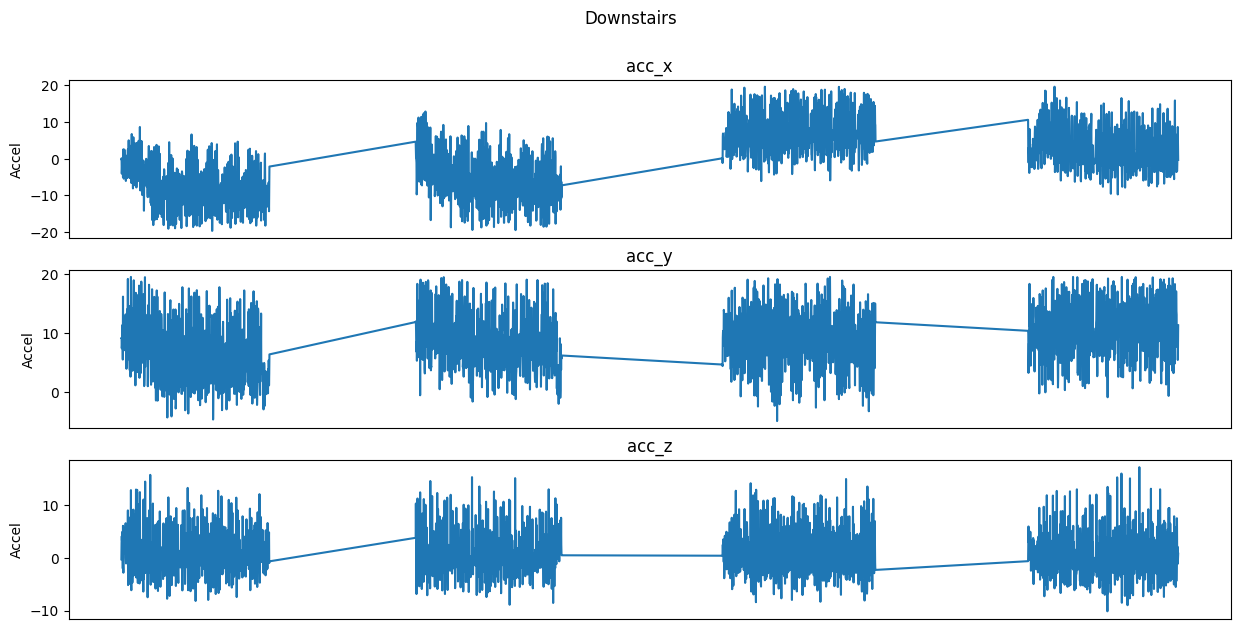

In [ ]:
data_labels = list(random_sample.columns[3:])
plt.figure(figsize=(15, 7))
for i, label in enumerate(data_labels):
  plt.subplot(3, 1, i+1)
  plt.plot(random_sample[label])
  plt.title(label)
  plt.ylabel('Accel')
  plt.xticks([])
  plt.suptitle(random_sample['activity'].unique()[0])
plt.show()

In [ ]:
# Removing noise
for i, axis in enumerate(data_labels):
  random_sample[axis] = remove_noise(random_sample[axis])
print(f"Noise Removed...")

Noise Removed...


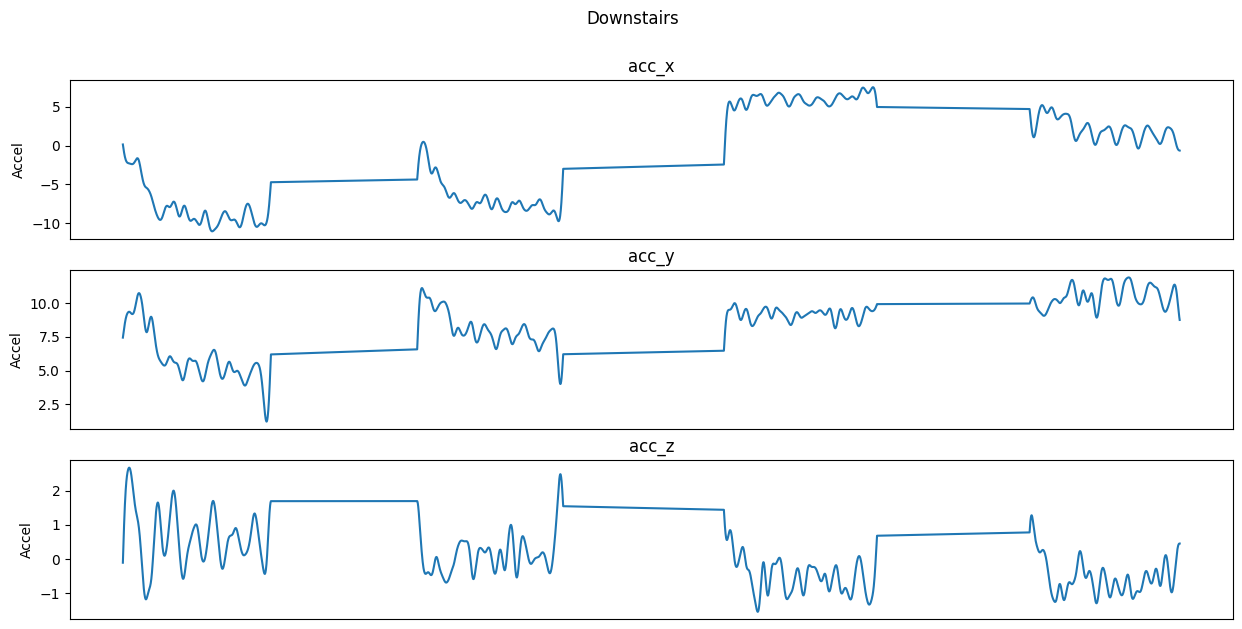

In [ ]:
data_labels = list(random_sample.columns[3:])
plt.figure(figsize=(15, 7))
for i, label in enumerate(data_labels):
  plt.subplot(3, 1, i+1)
  plt.plot(random_sample[label])
  plt.title(label)
  plt.ylabel('Accel')
  plt.xticks([])
  plt.suptitle(random_sample['activity'].unique()[0])
plt.show()

In [ ]:
test = random_sample.copy()
test.shape

(2941, 6)

### Segmentation Code

In [ ]:
import scipy.stats as stats

In [ ]:
fs = 50
frame_size= fs * 4
hop_size = fs * 2

In [ ]:
def get_frames(df, frame_size, hop_size):
  n_features = 3
  frames = []
  labels = []
  for i in range(0, len(df) - frame_size, hop_size):
    x = df['acc_x'].values[i: i + frame_size]
    y = df['acc_y'].values[i: i + frame_size]
    z = df['acc_z'].values[i: i + frame_size]

    label = df['activity'][i:i+frame_size].mode()[0]
    frames.append([x, y, z])
    labels.append(label)

  frames = np.array(frames).reshape(-1, frame_size, n_features)
  labels = np.array(labels)

  return frames, labels

In [ ]:
segments, labels_ = get_frames(df=test.copy(), frame_size=frame_size, hop_size=hop_size)

In [ ]:
print(f"Segmented data shape: {segments.shape}, labels shape: {labels_.shape}")

Segmented data shape: (28, 200, 3), labels shape: (28,)


## Applying All Preprocessing on entire dataset

---



In [ ]:
wisdm_dataset = dataset.copy()
wisdm_dataset.head()

,user,activity,timestamp,acc_x,acc_y,acc_z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [ ]:
# Removing Noise
for i, label in tqdm(enumerate(wisdm_dataset.columns[3:])):
  wisdm_dataset[label] = remove_noise(wisdm_dataset[label])

3it [00:00,  8.90it/s]


In [ ]:
wisdm_dataset['activity'].value_counts()

activity
Walking       424399
Jogging       342179
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: Int64

In [ ]:
wisdm_dataset['user'].value_counts()

user
20    56632
19    45383
31    44282
8     41188
29    38245
14    38192
13    37093
34    35948
32    35506
21    35436
3     35161
27    34959
10    34883
18    32812
12    32641
26    32578
36    32261
11    31658
7     30967
1     29978
6     29704
33    29453
5     28510
15    28155
24    25736
23    25673
30    25335
2     23525
35    22394
22    22310
17    22020
28    21358
16    20470
25    13468
9     12923
4     11371
Name: count, dtype: Int64

### Split Dataset into 3 sets - train, test, validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
X = wisdm_dataset[['acc_x', 'acc_y', 'acc_z']].copy()

In [ ]:
scaler = StandardScaler()

In [ ]:
X_scaled = scaler.fit_transform(X)

In [ ]:
scaled = pd.DataFrame(data=X_scaled, columns=['acc_x', 'acc_y', 'acc_z'])
scaled['activity'] = wisdm_dataset['activity'].values

In [ ]:
scaled

,acc_x,acc_y,acc_z,activity
0,-0.075357,1.028962,-0.097708,Jogging
1,-0.087947,0.970919,0.000502,Jogging
2,-0.099166,0.913613,0.097494,Jogging
3,-0.108950,0.857216,0.192420,Jogging
4,-0.117253,0.801901,0.284485,Jogging
...,...,...,...,...
1098203,1.920230,-2.252222,0.797722,Sitting
1098204,1.920101,-2.252551,0.791128,Sitting
1098205,1.919976,-2.252815,0.785101,Sitting
1098206,1.919855,-2.253019,0.779690,Sitting


In [ ]:
segments, labels = get_frames(scaled, frame_size, hop_size)

In [ ]:
lab_enc = LabelEncoder()
labels = lab_enc.fit_transform(labels)
labels.shape

(10981,)

In [ ]:
lab_enc.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype='<U10')

In [ ]:
x_train, x_, y_train, y_ = train_test_split(segments, labels, test_size=0.2, random_state=32)
x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size=0.3, random_state=32)

In [ ]:
print(f"[Training] {x_train.shape}, labels: {y_train.shape}")
print(f"[Testing] {x_test.shape}, labels: {y_test.shape}")
print(f"[Validation] {x_val.shape}, labels: {y_val.shape}")


[Training] (8784, 200, 3), labels: (8784,)
[Testing] (660, 200, 3), labels: (660,)
[Validation] (1537, 200, 3), labels: (1537,)


In [ ]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_val = np.expand_dims(x_val, axis=3)

In [ ]:
from keras.utils import to_categorical

In [ ]:
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)
y_val = to_categorical(y_val, num_classes=6)

In [ ]:
print(f"[Training] {x_train.shape}, labels: {y_train.shape}")
print(f"[Testing] {x_test.shape}, labels: {y_test.shape}")
print(f"[Validation] {x_val.shape}, labels: {y_val.shape}")


[Training] (8784, 200, 3, 1), labels: (8784, 6)
[Testing] (660, 200, 3, 1), labels: (660, 6)
[Validation] (1537, 200, 3, 1), labels: (1537, 6)


### Segmentation

### Building Model

In [ ]:
from keras import layers, models, optimizers, callbacks
import keras.backend as K
from tensorflow.keras.layers import Multiply

### Model Training

In [ ]:
import tensorflow as tf
from keras.layers import LayerNormalization, Dense, Activation, Dropout, add, MultiHeadAttention, Conv1D, BatchNormalization, Input, Flatten, Reshape
from keras.activations import sigmoid

In [ ]:
def swish(x):
  return (sigmoid(x) * x)

def glu(x):
  split_size = x.shape[-1] // 2
  x1, x2 = tf.split(x, num_or_size_splits=2, axis=-1)
  x2 = sigmoid(x2)

  return x1 * x2

def ffm(inputs, dropout=0.15):
  x = LayerNormalization()(inputs)
  x = Dense(16)(x)
  x = Activation(swish)(x)
  x = Dropout(dropout)(x)
  x = Dense(1, activation='relu')(x)
  x = Dropout(dropout)(x)

  return add([x, inputs])

def mmsa(inputs, dropout=0.1):
  x = LayerNormalization()(inputs)
  x  = MultiHeadAttention(num_heads=3, key_dim=32//3, value_dim=3)(x, x) #(num_heads=3, key_dim=3, value_dim=3)(x, x)
  x = Dropout(dropout)(x)

  return add([x, inputs])

def conv_module(inputs, dropout=0.1, filters=256):
  x = LayerNormalization()(inputs)
  x = Conv1D(filters=filters, kernel_size=1, padding='same')(x)
  x = Activation(glu)(x)

  x = Conv1D(filters=filters, kernel_size=32, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(swish)(x)

  x = Conv1D(filters=filters, kernel_size=1, activation='relu', padding='same')(x)
  x = Dropout(dropout)(x)

  return add([x, inputs])

def conformer_block(input_):
  xi_hat = (ffm(inputs=input_, dropout=0.15) * 0.5) + input_
  xi_prime = xi_hat + mmsa(inputs=xi_hat, dropout=0.0)
  xi_pprime = xi_prime + conv_module(inputs=xi_prime, dropout=0.1, filters=256)

  y = LayerNormalization()(xi_pprime + 0.5*ffm(xi_pprime, dropout=0.15))

  return y

def ssensor_attention_block(input_):
  num_filters = input_.shape[-1]
  kernel_size=3
  padding_type = 'same'

  x = Conv1D(num_filters, kernel_size, padding=padding_type, activation='relu')(input_)
  x = Flatten()(x)
  x = Activation('softmax')(x)
  x = Reshape((input_.shape[1], 3, 1))(x)
  x = input_ * x

  return x

In [ ]:
inputs = Input(shape=x_train[0].shape)
#x = ffm(inputs=inputs, dropout=0.15)
#x = mmsa(inputs=x, dropout=0.1)
#x = conv_module(inputs=x, dropout=0.1, filters=256)
x = ssensor_attention_block(input_=inputs)

for _ in range(3):
  x = Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)

for _ in range(3):
  x = conformer_block(input_=x)

x = Flatten()(x)
x = Activation('relu')(x)
#x = layers.Dense(126, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

outputs = Dense(6, activation='softmax')(x)
model3 = models.Model(inputs, outputs)

model3.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 200, 3, 1)]          0         []                            
                                                                                                  
 conv1d_144 (Conv1D)         (None, 200, 3, 1)            4         ['input_13[0][0]']            
                                                                                                  
 flatten_22 (Flatten)        (None, 600)                  0         ['conv1d_144[0][0]']          
                                                                                                  
 activation_148 (Activation  (None, 600)                  0         ['flatten_22[0][0]']          
 )                                                                                         

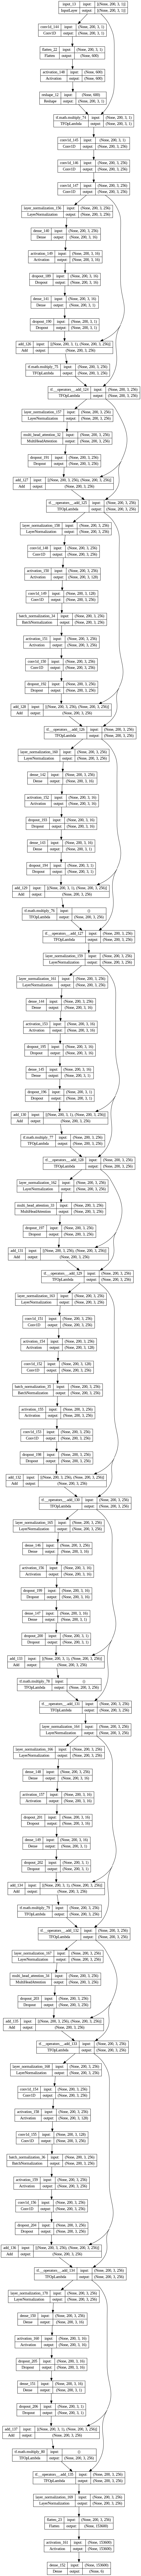

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LayerNormalization, Dense, Activation, Dropout, Add, Conv1D, BatchNormalization, Flatten, Reshape
from tensorflow.keras.activations import sigmoid

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-5)
model_checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
optim = optimizers.Adam(learning_rate=1e-4, weight_decay=0.0001)
model3.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist2 = model3.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), verbose=1, callbacks=[reduce_lr, model_checkpoint])

Epoch 1/50
275/275 [==============================] - ETA: 0s - loss: 1.6558 - accuracy: 0.4602

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/275 [==============================] - 56s 131ms/step - loss: 1.6558 - accuracy: 0.4602 - val_loss: 1.9128 - val_accuracy: 0.4463 - lr: 1.0000e-04
Epoch 2/50
275/275 [==============================] - 33s 121ms/step - loss: 1.2711 - accuracy: 0.5550 - val_loss: 1.4547 - val_accuracy: 0.4600 - lr: 1.0000e-04
Epoch 3/50
275/275 [==============================] - 33s 120ms/step - loss: 1.1718 - accuracy: 0.5987 - val_loss: 1.8055 - val_accuracy: 0.2739 - lr: 1.0000e-04
Epoch 4/50
275/275 [==============================] - 33s 121ms/step - loss: 1.1540 - accuracy: 0.6030 - val_loss: 1.7032 - val_accuracy: 0.3761 - lr: 1.0000e-04
Epoch 5/50
275/275 [==============================] - 33s 120ms/step - loss: 1.0759 - accuracy: 0.6300 - val_loss: 1.9147 - val_accuracy: 0.4249 - lr: 1.0000e-04
Epoch 6/50
275/275 [==============================] - 33s 121ms/step - loss: 1.0017 - accuracy: 0.6560 - val_loss: 2.3586 - val_accuracy: 0.3832 - lr: 1.0000e-04
Epoch 7/50
275/275 [===================

In [ ]:
y_val.shape

(1537, 6)

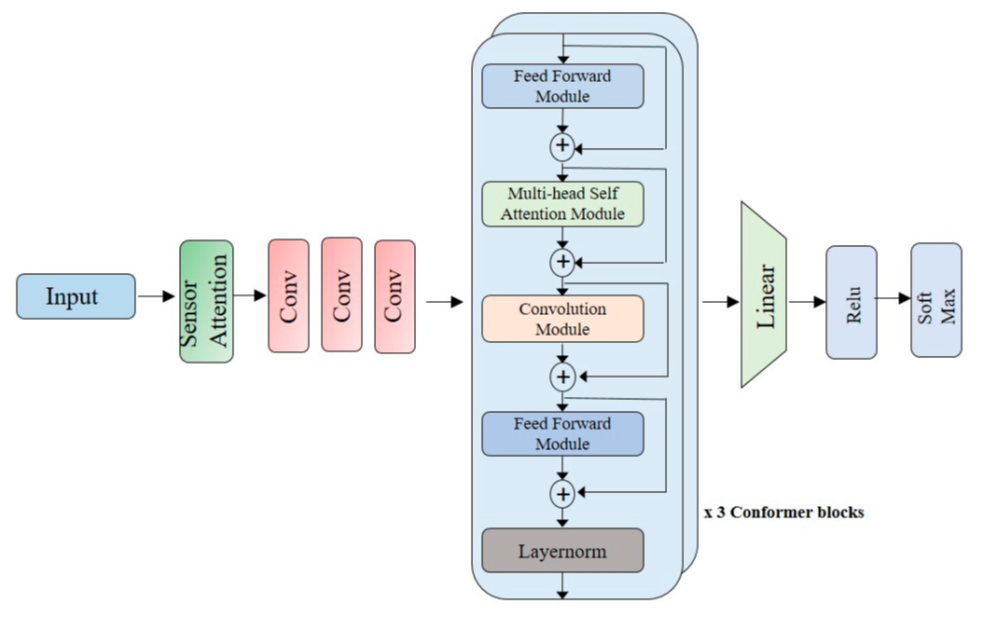

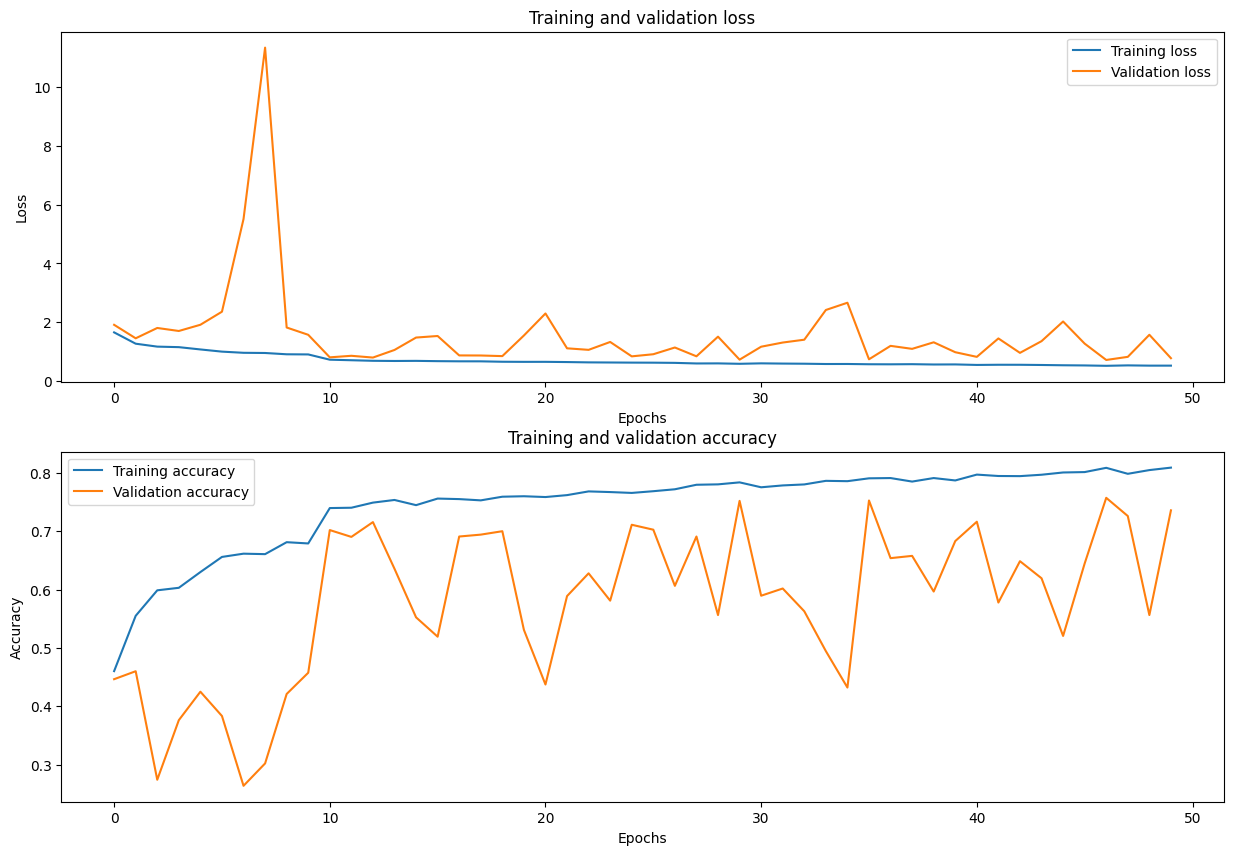

In [ ]:
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']
accuracy = hist2.history['accuracy']
val_accuracy = hist2.history['val_accuracy']

epochs = range(len(loss))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(epochs, loss, label='Training loss')
ax1.plot(epochs, val_loss, label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, accuracy, label='Training accuracy')
ax2.plot(epochs, val_accuracy, label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()


In [ ]:
import pickle

with open('history.pkl', 'wb') as f:
  pickle.dump(hist2.history, f)


### GROUND TRUTH EVALUATION 1

---



---



In [ ]:
preds = model3.predict(x_test)

21/21 [==============================] - 3s 56ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

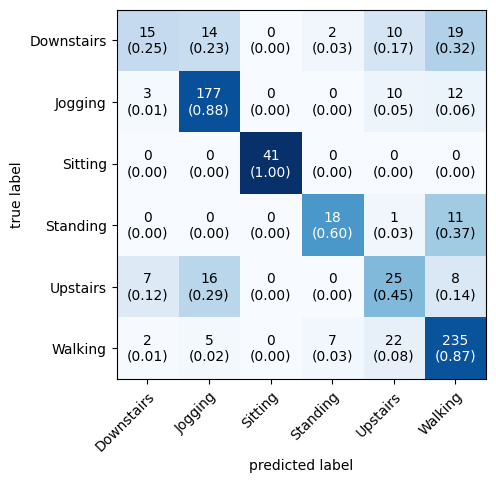

In [ ]:
mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(preds, axis=1))
plot_confusion_matrix(conf_mat=mat, show_normed=True, class_names=lab_enc.classes_)#['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'])

In [ ]:
np.argmax(y_test, axis=1)

array([1, 3, 1, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 4, 5, 0, 5, 4, 5, 5, 3,
       1, 1, 1, 5, 1, 1, 2, 4, 4, 1, 4, 1, 0, 5, 5, 1, 2, 3, 4, 1, 0, 5,
       5, 5, 5, 5, 1, 1, 5, 0, 5, 4, 5, 5, 0, 5, 1, 5, 5, 0, 1, 3, 2, 5,
       1, 1, 0, 5, 5, 2, 1, 5, 1, 5, 0, 5, 5, 1, 5, 4, 1, 5, 1, 5, 1, 3,
       1, 1, 1, 5, 4, 5, 1, 1, 5, 0, 5, 1, 5, 5, 1, 3, 0, 5, 3, 5, 2, 5,
       5, 0, 4, 5, 0, 1, 5, 1, 3, 1, 1, 1, 2, 5, 1, 0, 5, 5, 1, 5, 3, 1,
       1, 4, 1, 5, 3, 5, 1, 1, 5, 1, 5, 5, 5, 5, 5, 1, 5, 1, 1, 0, 5, 5,
       5, 5, 5, 1, 1, 0, 1, 5, 1, 1, 5, 4, 2, 1, 5, 1, 0, 5, 5, 5, 1, 5,
       2, 5, 5, 0, 5, 1, 2, 5, 5, 1, 5, 2, 3, 5, 5, 1, 5, 4, 4, 1, 1, 0,
       5, 5, 5, 1, 4, 4, 1, 1, 1, 5, 3, 1, 5, 5, 1, 1, 1, 4, 3, 3, 5, 1,
       2, 5, 1, 5, 5, 1, 1, 0, 1, 1, 1, 4, 1, 5, 4, 5, 4, 0, 1, 1, 5, 0,
       5, 5, 2, 5, 1, 5, 1, 4, 1, 5, 5, 1, 2, 5, 4, 1, 5, 3, 1, 3, 1, 1,
       0, 5, 5, 5, 0, 5, 0, 2, 0, 5, 5, 1, 3, 1, 2, 0, 1, 2, 5, 4, 5, 4,
       1, 5, 1, 0, 2, 1, 2, 5, 5, 5, 5, 1, 1, 5, 0,

In [ ]:
from sklearn.metrics import classification_report

y_pred = model3.predict(x_test)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_true, y_pred_classes)

21/21 [==============================] - 1s 56ms/step


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.56      0.25      0.34        60
           1       0.83      0.88      0.86       202
           2       1.00      1.00      1.00        41
           3       0.67      0.60      0.63        30
           4       0.37      0.45      0.40        56
           5       0.82      0.87      0.85       271

    accuracy                           0.77       660
   macro avg       0.71      0.67      0.68       660
weighted avg       0.77      0.77      0.77       660



In [ ]:
model3.save('conformer_model_50ACC.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files

In [ ]:
files.download('./conformer_model80epoch.h5')

FileNotFoundError: Cannot find file: ./conformer_model80epoch.h5

In [ ]:
files.download('./history80epoch.pkl')

### GROUND TRUTH EVALUATION 2

---



---



In [ ]:
sensor_path = './recording.csv'

In [ ]:
sensor_data = pd.read_csv(sensor_path)

In [ ]:
sensor_data

,user,activity,timestamp,acc_x,acc_y,acc_z
0,1,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,1,Jogging,49106062271000,5.012288,11.264028,0.953424
2,1,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,1,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,1,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
86080,2,Standing,59808782330000,-1.310000,9.960000,0.570000
86081,2,Standing,59808832317000,-1.310000,9.920000,0.650000
86082,2,Standing,59808882305000,-1.310000,9.890000,0.690000
86083,2,Standing,59808882305000,-1.310000,9.890000,0.690000


In [ ]:
fs = 50
frame_size= fs * 4
hop_size = fs * 2

def get_frames(df, frame_size, hop_size):
  n_features = 3
  frames = []
  labels = []
  for i in range(0, len(df) - frame_size, hop_size):
    x = df['acc_x'].values[i: i + frame_size]
    y = df['acc_y'].values[i: i + frame_size]
    z = df['acc_z'].values[i: i + frame_size]

    label = df['activity'][i:i+frame_size].mode()[0]
    frames.append([x, y, z])
    labels.append(label)

  frames = np.array(frames).reshape(-1, frame_size, n_features)
  labels = np.array(labels)

  return frames, labels

In [ ]:
new_data = sensor_data.drop(columns=['timestamp', 'user'])

In [ ]:
X = new_data[['acc_x', 'acc_y', 'acc_z']].copy()
#scaler = StandardScaler()
#lab_map = {'Downstairs': 0, 'Jogging':1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
new_data['activity'] = lab_enc.transform(new_data['activity'])
X_scaled = scaler.transform(X)
scaled = pd.DataFrame(X_scaled, columns = ['acc_x', 'acc_y', 'acc_z'])
scaled['activity'] = new_data['activity'].values

In [ ]:
segments, labels = get_frames(scaled, frame_size, hop_size)

In [ ]:
segments = np.expand_dims(segments, axis=3)
labels = to_categorical(labels, num_classes=6)
#zeros_column = np.zeros((labels.shape[0], 1))
#labels = np.hstack((labels, zeros_column))
print(f"Segments: {segments.shape}, labels: {labels.shape}")

Segments: (859, 200, 3, 1), labels: (859, 6)


In [ ]:
preds = model3.predict(segments)

27/27 [==============================] - 2s 58ms/step


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

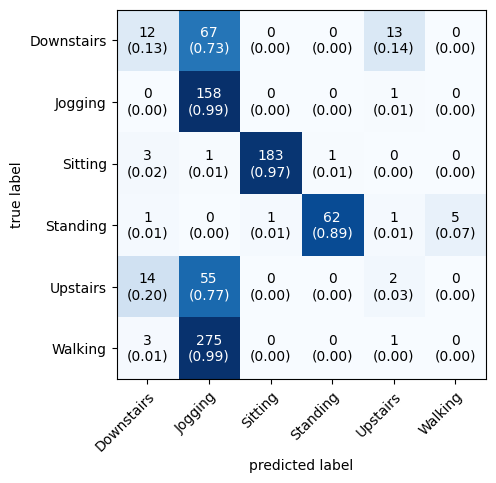

In [ ]:
mat = confusion_matrix(np.argmax(labels, axis=1), np.argmax(preds, axis=1))
plot_confusion_matrix(conf_mat=mat, show_normed=True, class_names=lab_enc.classes_)#['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])

In [ ]:
y_pred = model3.predict(segments)
y_true = np.argmax(labels, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_true, y_pred_classes)

27/27 [==============================] - 1s 46ms/step


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.36      0.13      0.19        92
           1       0.28      0.99      0.44       159
           2       0.99      0.97      0.98       188
           3       0.98      0.89      0.93        70
           4       0.11      0.03      0.04        71
           5       0.00      0.00      0.00       279

    accuracy                           0.49       859
   macro avg       0.46      0.50      0.43       859
weighted avg       0.40      0.49      0.40       859



### GROUND TRUTH EVALUATION 3

---



---



In [ ]:
import os

In [ ]:
filename = './datarecorded.zip'
with zipfile.ZipFile(filename, 'r') as zip_ref:
  zip_ref.extractall('./')

In [ ]:
gt_path = './datarecorded/'
gt_files = [gt_path + file for file in os.listdir(gt_path)]
new_data = pd.DataFrame()

In [ ]:
for file_ in gt_files:
  with open(file_, 'r') as f:
    lines = f.readlines()

  z = []
  for line in lines:
    z.append(line.strip().split(';'))
  z = np.array(z)
  t = pd.DataFrame(z[1:, :], columns=z[0, :])
  fname_label = file_.split('.csv')[0].split('/')[-1].split('_')[0]
  t['activity'] = fname_label



  new_data = pd.concat([new_data, t])

new_data['t_Android'] = new_data['t_Android'].astype(int)
new_data['t_unix'] = new_data['t_unix'].astype(int)
new_data['x'] = new_data['x'].astype(float)
new_data['y'] = new_data['y'].astype(float)
new_data['z'] = new_data['z'].astype(float)
new_data['a'] = new_data['a'].astype(int)
new_data['activity'] = new_data['activity'].astype(str)

In [ ]:
fs = 50
frame_size= fs * 4
hop_size = fs * 2

def get_frames(df, frame_size, hop_size):
  n_features = 3
  frames = []
  labels = []
  for i in range(0, len(df) - frame_size, hop_size):
    x = df['x'].values[i: i + frame_size]
    y = df['y'].values[i: i + frame_size]
    z = df['z'].values[i: i + frame_size]

    label = df['activity'][i:i+frame_size].mode()[0]
    frames.append([x, y, z])
    labels.append(label)

  frames = np.array(frames).reshape(-1, frame_size, n_features)
  labels = np.array(labels)

  return frames, labels

In [ ]:
new_data = new_data.drop(columns=['t_Android', 't_unix', 'a'])

In [ ]:
X = new_data[['x', 'y', 'z']].copy()
scaler = StandardScaler()
lab_map = {'Downstairs': 0, 'Jogging':1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
new_data['activity'] = lab_enc.transform(new_data['activity'])#new_data['activity'].map(lab_map)
X_scaled = scaler.fit_transform(X)
scaled = pd.DataFrame(X_scaled, columns = ['x', 'y', 'z'])
scaled['activity'] = new_data['activity'].values

In [ ]:
segments, labels = get_frames(scaled, frame_size, hop_size)

In [ ]:
segments = np.expand_dims(segments, axis=3)
labels = to_categorical(labels, num_classes=6)
#zeros_column = np.zeros((labels.shape[0], 1))
#labels = np.hstack((labels, zeros_column))
print(f"Segments: {segments.shape}, labels: {labels.shape}")

Segments: (169, 200, 3, 1), labels: (169, 6)


In [ ]:
preds = model3.predict(segments)

6/6 [==============================] - 0s 72ms/step


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

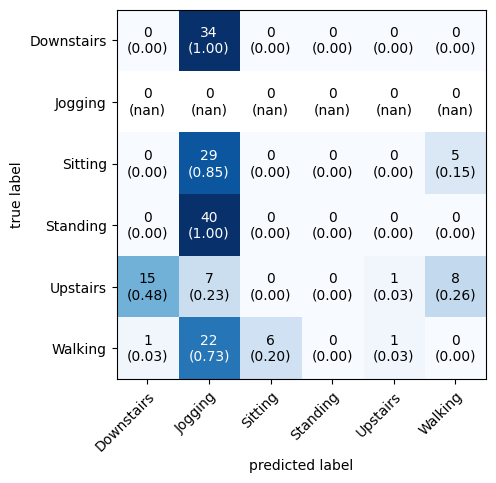

In [ ]:
mat = confusion_matrix(np.argmax(labels, axis=1), np.argmax(preds, axis=1))
plot_confusion_matrix(conf_mat=mat, show_normed=True, class_names=lab_enc.classes_)#['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])

In [ ]:
y_pred = model3.predict(segments)
y_true = np.argmax(labels, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_true, y_pred_classes)

6/6 [==============================] - 0s 57ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00        40
           4       0.50      0.03      0.06        31
           5       0.00      0.00      0.00        30

    accuracy                           0.01       169
   macro avg       0.08      0.01      0.01       169
weighted avg       0.09      0.01      0.01       169

